# Logistic Regression 

In [19]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

print("\nFeature names:", features)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Extract names separately
train_names = train_df['Name']
test_names = test_df['Name']

print("\nNumber of train samples:", len(train_names))
print("Number of test samples:", len(test_names))

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

print("\nUnique primary types in train:", y_train_primary.nunique())
print("Unique primary types in test:", y_test_primary.nunique())
print("Unique generations in train:", y_train_generation.nunique())
print("Unique generations in test:", y_test_generation.nunique())

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

print("\nSample of y_train_both:", y_train_both[:5])
print("Sample of y_test_both:", y_test_both[:5])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nX_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

print("\ny_train_both_bin shape:", y_train_both_bin.shape)
print("y_test_both_bin shape:", y_test_both_bin.shape)
print("Classes:", mlb.classes_)

print("\nSample of y_train_both_bin:", y_train_both_bin[:5])
print("Sample of y_test_both_bin:", y_test_both_bin[:5])

Train dataset shape: (820, 14)
Test dataset shape: (205, 14)

Feature names: ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train shape: (820, 8)
X_test shape: (205, 8)

Number of train samples: 820
Number of test samples: 205

Unique primary types in train: 18
Unique primary types in test: 18
Unique generations in train: 9
Unique generations in test: 9

Sample of y_train_both: [['Dark', 'Psychic'], ['Psychic'], ['Psychic'], ['Normal', 'Flying'], ['Ghost']]
Sample of y_test_both: [['Dragon', 'Fighting'], ['Dark'], ['Normal', 'Psychic'], ['Grass'], ['Bug', 'Ground']]

X_train_scaled shape: (820, 8)
X_test_scaled shape: (205, 8)

y_train_both_bin shape: (820, 18)
y_test_both_bin shape: (205, 18)
Classes: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']

Sample of y_train_both_bin: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0

In [20]:
# Baseline without CV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score
import numpy as np

# Define evaluation metrics for both types
def precision_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    precisions = [np.sum(y_true[i, top_k_pred[i]]) / k for i in range(len(y_true))]
    return np.mean(precisions)

def recall_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    recalls = [np.sum(y_true[i, top_k_pred[i]]) / np.sum(y_true[i]) for i in range(len(y_true))]
    return np.mean(recalls)

# Primary Type
lr_primary = LogisticRegression(max_iter=1000)
lr_primary.fit(X_train_scaled, y_train_primary)
y_pred_primary = lr_primary.predict(X_test_scaled)
print("Logistic Regression - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types uses OneVsRestClassifier
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_both.fit(X_train_scaled, y_train_both_bin)

# Get probabilities for each class
y_pred_both_probas = lr_both.predict_proba(X_test_scaled)

# Initialize predictions array
y_pred_both = np.zeros_like(y_test_both_bin)

# Define a probability threshold
threshold = 0.5  # Adjust this threshold based on your needs

# Ensure at least one type is predicted for each Pokémon
for i in range(len(y_test_both_bin)):
    # Extract probabilities for each type for sample i
    probas = y_pred_both_probas[i]

    # Predict types with probabilities above the threshold
    above_threshold = probas >= threshold

    if not np.any(above_threshold):
        # If no type is above the threshold, predict the type with the highest probability
        max_index = probas.argmax()
        y_pred_both[i, max_index] = 1
    else:
        # Otherwise, predict all types above the threshold
        y_pred_both[i, above_threshold] = 1

print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")

# Calculate Precision@2 and Recall@2
precision_at_2 = precision_at_k(y_test_both_bin, y_pred_both_probas, k=2)
recall_at_2 = recall_at_k(y_test_both_bin, y_pred_both_probas, k=2)

print(f"Precision@2: {precision_at_2:.3f}")
print(f"Recall@2: {recall_at_2:.3f}")

# Generation
lr_generation = LogisticRegression(max_iter=1000)
lr_generation.fit(X_train_scaled, y_train_generation)
y_pred_generation = lr_generation.predict(X_test_scaled)
print("Logistic Regression - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Logistic Regression - Primary Type Accuracy: 0.23902439024390243
Logistic Regression - Both Types Hamming Loss: 0.1070460704607046
Exact Match Ratio: 0.122
Jaccard Similarity Score: 0.199
F1 Score: 0.224
Precision@2: 0.229
Recall@2: 0.332
Logistic Regression - Generation Accuracy: 0.2


### Precision and Recall Interpretation

Precision@2: 0.229 (22.9%)
This means that, on average, 22.9% of the top 2 predicted types for each Pokémon are correct.
In other words, if the model predicts two types for each Pokémon, about 1 in 4 of these predictions is correct.
###
Recall@2: 0.332 (33.2%)
This indicates that, on average, 33.2% of the actual types of each Pokémon are captured within the top 2 predictions.
It suggests that about one-third of the true types are being identified in the top 2 predictions.

In [3]:
# Comprehensive Output of Model
import numpy as np
import pandas as pd

# Function to create DataFrame for misclassified and correctly classified cases
def create_classification_df(test_names, actual_labels, predicted_labels, label_type):
    misclassified_indices = np.where(actual_labels != predicted_labels)[0]
    correct_indices = np.where(actual_labels == predicted_labels)[0]

    # Misclassified DataFrame
    misclassified_df = pd.DataFrame({
        'Name': test_names.iloc[misclassified_indices],
        f'Actual {label_type}': actual_labels[misclassified_indices],
        f'Predicted {label_type}': predicted_labels[misclassified_indices]
    })

    # Correctly classified DataFrame
    correct_df = pd.DataFrame({
        'Name': test_names.iloc[correct_indices],
        f'Actual {label_type}': actual_labels[correct_indices],
        f'Predicted {label_type}': predicted_labels[correct_indices]
    })

    return misclassified_df, correct_df

# Primary Type Classification
misclassified_primary_df, correct_primary_df = create_classification_df(
    test_names,
    y_test_primary,
    y_pred_primary,
    "Primary"
)

# Both Types Classification
misclassified_both_indices = np.where(np.any(y_test_both_bin != y_pred_both, axis=1))[0]
correct_both_indices = np.where(np.all(y_test_both_bin == y_pred_both, axis=1))[0]

misclassified_both_df = pd.DataFrame({
    'Name': test_names.iloc[misclassified_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices]
})

correct_both_df = pd.DataFrame({
    'Name': test_names.iloc[correct_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in correct_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in correct_both_indices]
})

# Generation Classification
misclassified_generation_df, correct_generation_df = create_classification_df(
    test_names,
    y_test_generation,
    y_pred_generation,
    "Generation"
)

# Print results
print("Misclassified Primary Types:")
print(misclassified_primary_df.head())
print(f"Total misclassifications: {len(misclassified_primary_df)}")
print(f"Misclassification rate: {len(misclassified_primary_df) / len(y_test_primary):.2%}\n")

print("Correctly Classified Primary Types:")
print(correct_primary_df.head())
print(f"Total correct classifications: {len(correct_primary_df)}")
print(f"Correct classification rate: {len(correct_primary_df) / len(y_test_primary):.2%}\n")

print("Misclassified Both Types:")
print(misclassified_both_df.head())
print(f"Total misclassifications: {len(misclassified_both_df)}")
print(f"Misclassification rate: {len(misclassified_both_df) / len(y_test_both_bin):.2%}\n")

print("Correctly Classified Both Types:")
print(correct_both_df.head())
print(f"Total correct classifications: {len(correct_both_df)}")
print(f"Correct classification rate: {len(correct_both_df) / len(y_test_both_bin):.2%}\n")

print("Misclassified Generations:")
print(misclassified_generation_df.head())
print(f"Total misclassifications: {len(misclassified_generation_df)}")
print(f"Misclassification rate: {len(misclassified_generation_df) / len(y_test_generation):.2%}\n")

print("Correctly Classified Generations:")
print(correct_generation_df.head())
print(f"Total correct classifications: {len(correct_generation_df)}")
print(f"Correct classification rate: {len(correct_generation_df) / len(y_test_generation):.2%}\n")

Misclassified Primary Types:
       Name Actual Primary Predicted Primary
0  Hakamo-o         Dragon             Water
1     Absol           Dark          Fighting
2  Meloetta         Normal           Psychic
3  Meganium          Grass             Water
6    Cubone         Ground             Water
Total misclassifications: 156
Misclassification rate: 76.10%

Correctly Classified Primary Types:
          Name Actual Primary Predicted Primary
4      Nincada            Bug               Bug
5   Conkeldurr       Fighting          Fighting
9    Poliwrath          Water             Water
18  Bouffalant         Normal            Normal
19      Bidoof         Normal            Normal
Total correct classifications: 49
Correct classification rate: 23.90%

Misclassified Both Types:
       Name      Actual Types Predicted Types
0  Hakamo-o  Dragon, Fighting           Water
1     Absol              Dark        Fighting
2  Meloetta   Normal, Psychic         Psychic
3  Meganium             Grass     

In [4]:
# Model Implementation
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Primary Type Prediction
lr_primary = LogisticRegression(max_iter=1000)

# Both Types Prediction
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Generation Prediction
lr_generation = LogisticRegression(max_iter=1000)

In [5]:
# suppress convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

EXAMPLE: The mean CV score of 0.213 is likely the average accuracy across the 5 folds of cross-validation. This indicates that, on average, the model correctly predicts the primary type for about 21.3% of the Pokémon in the validation sets.

In [6]:
# Results
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

# Primary Type Prediction
print("Primary Type Prediction:")

# Before tuning
scores_primary_before = cross_val_score(lr_primary, X_train_scaled, y_train_primary, cv=5)
print(f"Before tuning - Mean CV score: {scores_primary_before.mean():.3f} (+/- {scores_primary_before.std() * 2:.3f})")

# After tuning
# REGULARIZATION IS THE HYPERPARAMETER
param_grid_primary = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
grid_search_primary = GridSearchCV(lr_primary, param_grid_primary, cv=5)
grid_search_primary.fit(X_train_scaled, y_train_primary)

print("Best parameters:", grid_search_primary.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_primary.best_score_:.3f}")

# Evaluate on test set
y_pred_primary = grid_search_primary.predict(X_test_scaled)
test_accuracy_primary = accuracy_score(y_test_primary, y_pred_primary)
print(f"Test set accuracy: {test_accuracy_primary:.3f}")

Primary Type Prediction:
Before tuning - Mean CV score: 0.217 (+/- 0.053)
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
After tuning - Best cross-validation score: 0.217
Test set accuracy: 0.239


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, hamming_loss, jaccard_score, f1_score
import numpy as np

# Both Types Prediction
print("\nBoth Types Prediction:")

# Define the model using OneVsRestClassifier
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Cross-validation before tuning
scores_both_before = cross_val_score(
    lr_both, X_train_scaled, y_train_both_bin, cv=5,
    scoring=make_scorer(hamming_loss, greater_is_better=False)
)
print(f"Before tuning - Mean CV Hamming Loss: {-scores_both_before.mean():.3f} (+/- {scores_both_before.std() * 2:.3f})")

# Grid search for hyperparameter tuning
param_grid_both = {
    'estimator__C': [0.1, 1, 10],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver': ['liblinear', 'saga']
}

grid_search_both = GridSearchCV(
    lr_both, param_grid_both, cv=5,
    scoring=make_scorer(hamming_loss, greater_is_better=False)
)

grid_search_both.fit(X_train_scaled, y_train_both_bin)

print("Best parameters:", grid_search_both.best_params_)
print(f"After tuning - Best cross-validation Hamming Loss: {-grid_search_both.best_score_:.3f}")

# Evaluate on test set
y_pred_both_probas = grid_search_both.predict_proba(X_test_scaled)

# Initialize predictions array
y_pred_both = np.zeros_like(y_test_both_bin)

# Define a probability threshold
threshold = 0.2  # Adjust this threshold based on your needs

# Ensure at least one type is predicted for each Pokémon
for i in range(len(y_test_both_bin)):
    # Directly access the probabilities for each type for sample i
    probas = y_pred_both_probas[i]  # No need for additional indexing
    
    # Debugging: Print probabilities for each sample
    # print(f"Sample {i} probabilities:", probas)

    # Predict types with probabilities above the threshold
    above_threshold = probas >= threshold

    if not np.any(above_threshold):
        # If no type is above the threshold, predict the type with the highest probability
        max_index = probas.argmax()
        # print(f"Sample {i}, No types above threshold. Max index: {max_index}, Probability: {probas[max_index]}")
        y_pred_both[i, max_index] = 1
    else:
        # Otherwise, predict all types above the threshold
        # print(f"Sample {i}, Types above threshold indices: {np.where(above_threshold)[0]}, Probabilities: {probas[above_threshold]}")
        y_pred_both[i, above_threshold] = 1

# print("Shape of y_pred_both:", y_pred_both.shape)
print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")


Both Types Prediction:
Before tuning - Mean CV Hamming Loss: 0.087 (+/- 0.003)
Best parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
After tuning - Best cross-validation Hamming Loss: 0.085
Logistic Regression - Both Types Hamming Loss: 0.11409214092140921
Exact Match Ratio: 0.098
Jaccard Similarity Score: 0.188
F1 Score: 0.222


### The Hamming loss is the fraction of labels that are incorrectly predicted. That means, on average, 8.2% of the labels in the dataset are incorrectly classified (either predicted as positive when they should be negative, or vice versa). However, this does not account for the fact 
The lower the Hamming loss, the better the model's performance. A perfect score would be 0, indicating no incorrect labels, while a score of 1 would mean all labels are incorrect for every instance. 
If an instance has multiple labels, Hamming loss checks each label one by one:
If a label is correctly predicted, it contributes 0 to the Hamming loss.
If a label is incorrectly predicted (either a positive label predicted as negative or vice versa), it contributes 1 to the Hamming loss.


In [8]:
# Generation Prediction
print("\nGeneration Prediction:")

# Before tuning
scores_gen_before = cross_val_score(lr_generation, X_train_scaled, y_train_generation, cv=5)
print(f"Before tuning - Mean CV score: {scores_gen_before.mean():.3f} (+/- {scores_gen_before.std() * 2:.3f})")

# After tuning
param_grid_gen = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
grid_search_gen = GridSearchCV(lr_generation, param_grid_gen, cv=5)
grid_search_gen.fit(X_train_scaled, y_train_generation)

print("Best parameters:", grid_search_gen.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_gen.best_score_:.3f}")

# Evaluate on test set
y_pred_gen = grid_search_gen.predict(X_test_scaled)
test_accuracy_gen = accuracy_score(y_test_generation, y_pred_gen)
print(f"Test set accuracy: {test_accuracy_gen:.3f}")


Generation Prediction:
Before tuning - Mean CV score: 0.154 (+/- 0.048)
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
After tuning - Best cross-validation score: 0.159
Test set accuracy: 0.195


In [9]:
# Function to create DataFrame for misclassified and correctly classified cases
def create_classification_df(test_names, actual_labels, predicted_labels, label_type):
    misclassified_indices = np.where(actual_labels != predicted_labels)[0]
    correct_indices = np.where(actual_labels == predicted_labels)[0]

    # Misclassified DataFrame
    misclassified_df = pd.DataFrame({
        'Name': test_names.iloc[misclassified_indices],
        f'Actual {label_type}': actual_labels[misclassified_indices],
        f'Predicted {label_type}': predicted_labels[misclassified_indices]
    })

    # Correctly classified DataFrame
    correct_df = pd.DataFrame({
        'Name': test_names.iloc[correct_indices],
        f'Actual {label_type}': actual_labels[correct_indices],
        f'Predicted {label_type}': predicted_labels[correct_indices]
    })

    return misclassified_df, correct_df

# Primary Type Classification
misclassified_primary_df, correct_primary_df = create_classification_df(
    test_names,
    y_test_primary,
    y_pred_primary,
    "Primary"
)

# Both Types Classification
misclassified_both_indices = np.where(np.any(y_test_both_bin != y_pred_both, axis=1))[0]
correct_both_indices = np.where(np.all(y_test_both_bin == y_pred_both, axis=1))[0]

misclassified_both_df = pd.DataFrame({
    'Name': test_names.iloc[misclassified_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices]
})

correct_both_df = pd.DataFrame({
    'Name': test_names.iloc[correct_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in correct_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in correct_both_indices]
})

# Generation Classification
misclassified_generation_df, correct_generation_df = create_classification_df(
    test_names,
    y_test_generation,
    # naming difference
    y_pred_gen,
    "Generation"
)

# Print results
print("Misclassified Primary Types:")
print(misclassified_primary_df.head())
print(f"Total misclassifications: {len(misclassified_primary_df)}")
print(f"Misclassification rate: {len(misclassified_primary_df) / len(y_test_primary):.2%}\n")

print("Correctly Classified Primary Types:")
print(correct_primary_df.head())
print(f"Total correct classifications: {len(correct_primary_df)}")
print(f"Correct classification rate: {len(correct_primary_df) / len(y_test_primary):.2%}\n")

print("Misclassified Both Types:")
print(misclassified_both_df.head())
print(f"Total misclassifications: {len(misclassified_both_df)}")
print(f"Misclassification rate: {len(misclassified_both_df) / len(y_test_both_bin):.2%}\n")

print("Correctly Classified Both Types:")
print(correct_both_df.head())
print(f"Total correct classifications: {len(correct_both_df)}")
print(f"Correct classification rate: {len(correct_both_df) / len(y_test_both_bin):.2%}\n")

print("Misclassified Generations:")
print(misclassified_generation_df.head())
print(f"Total misclassifications: {len(misclassified_generation_df)}")
print(f"Misclassification rate: {len(misclassified_generation_df) / len(y_test_generation):.2%}\n")

print("Correctly Classified Generations:")
print(correct_generation_df.head())
print(f"Total correct classifications: {len(correct_generation_df)}")
print(f"Correct classification rate: {len(correct_generation_df) / len(y_test_generation):.2%}\n")

Misclassified Primary Types:
       Name Actual Primary Predicted Primary
0  Hakamo-o         Dragon             Water
1     Absol           Dark          Fighting
2  Meloetta         Normal           Psychic
3  Meganium          Grass             Water
6    Cubone         Ground             Water
Total misclassifications: 156
Misclassification rate: 76.10%

Correctly Classified Primary Types:
          Name Actual Primary Predicted Primary
4      Nincada            Bug               Bug
5   Conkeldurr       Fighting          Fighting
9    Poliwrath          Water             Water
18  Bouffalant         Normal            Normal
19      Bidoof         Normal            Normal
Total correct classifications: 49
Correct classification rate: 23.90%

Misclassified Both Types:
       Name      Actual Types Predicted Types
0  Hakamo-o  Dragon, Fighting           Water
1     Absol              Dark        Fighting
2  Meloetta   Normal, Psychic         Psychic
3  Meganium             Grass     

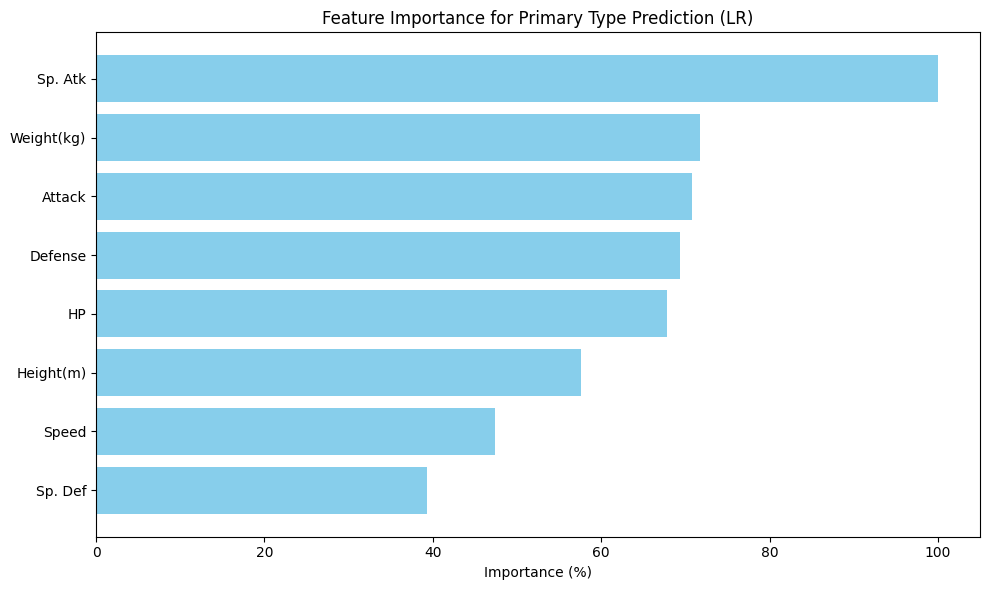

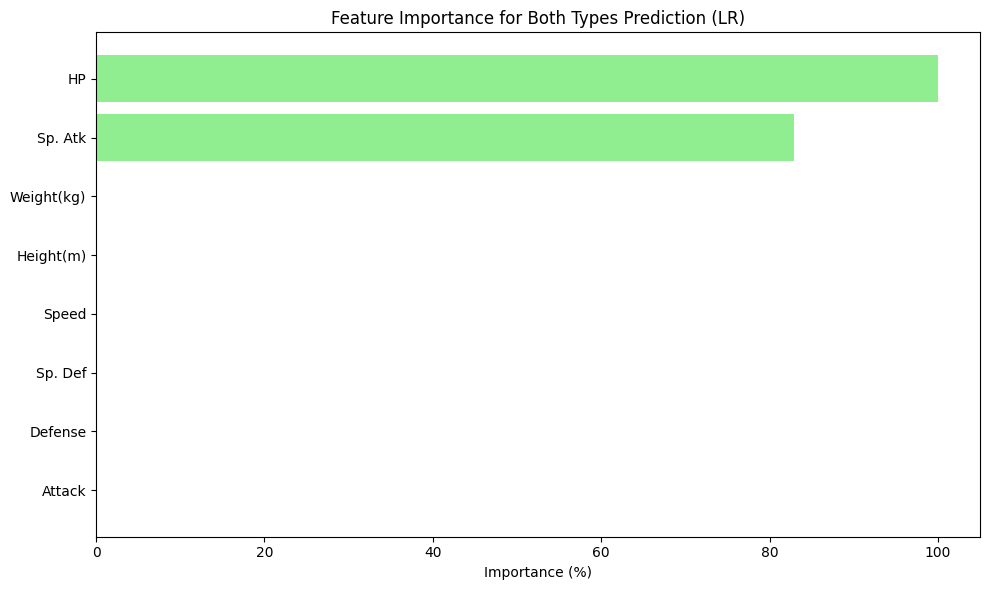

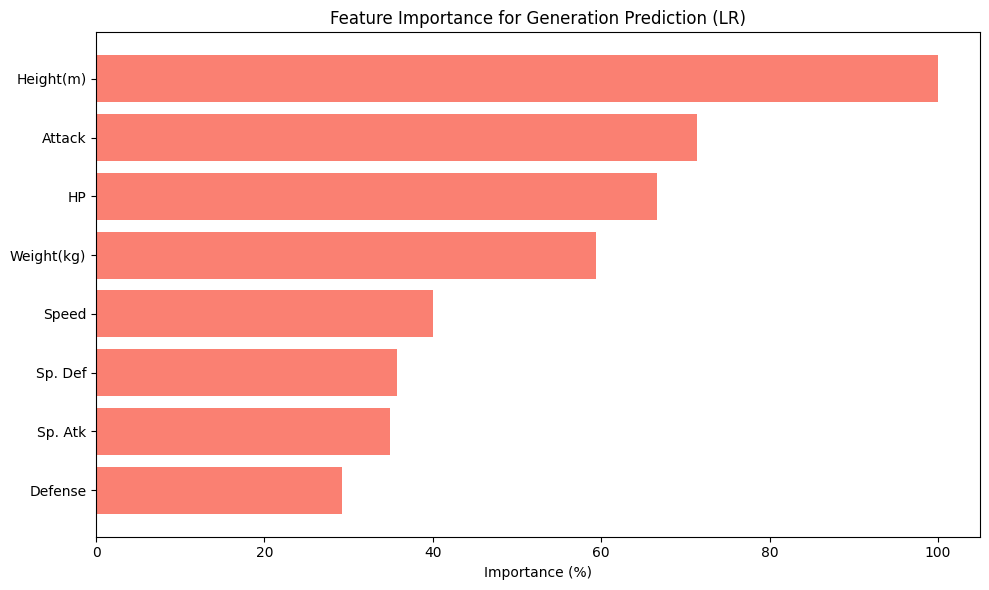

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Primary Type Feature Importance
primary_importance = np.abs(grid_search_primary.best_estimator_.coef_).mean(axis=0)
primary_importance = 100.0 * (primary_importance / primary_importance.max())
sorted_primary_indices = np.argsort(primary_importance)[::-1]
sorted_primary_importance = primary_importance[sorted_primary_indices]
sorted_primary_features = [features[i] for i in sorted_primary_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_primary_features, sorted_primary_importance, color='skyblue')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Primary Type Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Both Types Feature Importance
both_importance = np.abs(grid_search_both.best_estimator_.estimators_[0].coef_).mean(axis=0)
both_importance = 100.0 * (both_importance / both_importance.max())
sorted_both_indices = np.argsort(both_importance)[::-1]
sorted_both_importance = both_importance[sorted_both_indices]
sorted_both_features = [features[i] for i in sorted_both_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_both_features, sorted_both_importance, color='lightgreen')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Both Types Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Generation Feature Importance
gen_importance = np.abs(grid_search_gen.best_estimator_.coef_).mean(axis=0)
gen_importance = 100.0 * (gen_importance / gen_importance.max())
sorted_gen_indices = np.argsort(gen_importance)[::-1]
sorted_gen_importance = gen_importance[sorted_gen_indices]
sorted_gen_features = [features[i] for i in sorted_gen_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_gen_features, sorted_gen_importance, color='salmon')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Generation Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

## Include Feature Engineering

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data with engineered features
train_df = pd.read_csv('engineered_csv/pokemon_train_engineered.csv')
test_df = pd.read_csv('engineered_csv/pokemon_test_engineered.csv')

# Define original and engineered features
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
engineered_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

# Combine original and engineered features
all_features = original_features + engineered_features

# Prepare features
X_train = train_df[all_features]
X_test = test_df[all_features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

# Handle categorical features
categorical_features = ['Size_Class', 'Speed_Tier']
X_train_cat = pd.get_dummies(train_df[categorical_features], prefix=categorical_features)
X_test_cat = pd.get_dummies(test_df[categorical_features], prefix=categorical_features)

# Ensure test set has all columns present in train set
for col in X_train_cat.columns:
    if col not in X_test_cat.columns:
        X_test_cat[col] = 0

# Align columns of test set with train set
X_test_cat = X_test_cat[X_train_cat.columns]

# Combine scaled numerical features with categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

print("Training set shape:", X_train_final.shape)
print("Test set shape:", X_test_final.shape)
print("Number of classes for multi-label classification:", len(mlb.classes_))

Training set shape: (820, 35)
Test set shape: (205, 35)
Number of classes for multi-label classification: 18


In [12]:
# Baseline without CV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score
import numpy as np

# Primary Type
lr_primary = LogisticRegression(max_iter=1000)
lr_primary.fit(X_train_final, y_train_primary)
y_pred_primary = lr_primary.predict(X_test_final)
print("Logistic Regression - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types uses OneVsRestClassifier
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_both.fit(X_train_final, y_train_both_bin)

# Get probabilities for each class
y_pred_both_probas = lr_both.predict_proba(X_test_final)

# Initialize predictions array
y_pred_both = np.zeros_like(y_test_both_bin)

# Define a probability threshold
threshold = 0.5  # Adjust this threshold based on your needs

# Ensure at least one type is predicted for each Pokémon
for i in range(len(y_test_both_bin)):
    # Extract probabilities for each type for sample i
    probas = y_pred_both_probas[i]

    # Predict types with probabilities above the threshold
    above_threshold = probas >= threshold

    if not np.any(above_threshold):
        # If no type is above the threshold, predict the type with the highest probability
        max_index = probas.argmax()
        y_pred_both[i, max_index] = 1
    else:
        # Otherwise, predict all types above the threshold
        y_pred_both[i, above_threshold] = 1

print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")

# Generation
lr_generation = LogisticRegression(max_iter=1000)
lr_generation.fit(X_train_final, y_train_generation)
y_pred_generation = lr_generation.predict(X_test_final)
print("Logistic Regression - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Logistic Regression - Primary Type Accuracy: 0.23902439024390243
Logistic Regression - Both Types Hamming Loss: 0.11246612466124661
Exact Match Ratio: 0.112
Jaccard Similarity Score: 0.180
F1 Score: 0.204
Logistic Regression - Generation Accuracy: 0.2926829268292683


### Cross Validation and Hyperparameter Tuning

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, hamming_loss, jaccard_score, f1_score, accuracy_score
import numpy as np

# Primary Type
print("\nPrimary Type Prediction:")
lr_primary = LogisticRegression(max_iter=1000)
scores_primary = cross_val_score(lr_primary, X_train_final, y_train_primary, cv=5, scoring='accuracy')
print(f"Before tuning - Mean CV Accuracy: {scores_primary.mean():.3f} (+/- {scores_primary.std() * 2:.3f})")

param_grid_primary = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search_primary = GridSearchCV(lr_primary, param_grid_primary, cv=5, scoring='accuracy')
grid_search_primary.fit(X_train_final, y_train_primary)
print("Best parameters:", grid_search_primary.best_params_)
print(f"After tuning - Best cross-validation Accuracy: {grid_search_primary.best_score_:.3f}")

y_pred_primary = grid_search_primary.predict(X_test_final)
print("Logistic Regression - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))


Primary Type Prediction:
Before tuning - Mean CV Accuracy: 0.229 (+/- 0.059)
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
After tuning - Best cross-validation Accuracy: 0.230
Logistic Regression - Primary Type Accuracy: 0.24878048780487805


In [18]:
# Both Types
print("\nBoth Types Prediction:")
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))
scores_both = cross_val_score(lr_both, X_train_final, y_train_both_bin, cv=5, 
                              scoring=make_scorer(hamming_loss, greater_is_better=False))
print(f"Before tuning - Mean CV Hamming Loss: {-scores_both.mean():.3f} (+/- {scores_both.std() * 2:.3f})")

param_grid_both = {
    'estimator__C': [0.1, 1, 10],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver': ['liblinear', 'saga']
}
grid_search_both = GridSearchCV(lr_both, param_grid_both, cv=5,
                                scoring=make_scorer(hamming_loss, greater_is_better=False))
grid_search_both.fit(X_train_final, y_train_both_bin)
print("Best parameters:", grid_search_both.best_params_)
print(f"After tuning - Best cross-validation Hamming Loss: {-grid_search_both.best_score_:.3f}")

y_pred_both_probas = grid_search_both.predict_proba(X_test_final)

# Initialize predictions array
y_pred_both = np.zeros_like(y_test_both_bin)

# Define a probability threshold
threshold = 0.2  # Adjust this threshold based on your needs

# Ensure at least one type is predicted for each Pokémon
for i in range(len(y_test_both_bin)):
    # Directly access the probabilities for each type for sample i
    probas = y_pred_both_probas[i]  # No need for additional indexing
    
    # Debugging: Print probabilities for each sample
    # print(f"Sample {i} probabilities:", probas)

    # Predict types with probabilities above the threshold
    above_threshold = probas >= threshold

    if not np.any(above_threshold):
        # If no type is above the threshold, predict the type with the highest probability
        max_index = probas.argmax()
        # print(f"Sample {i}, No types above threshold. Max index: {max_index}, Probability: {probas[max_index]}")
        y_pred_both[i, max_index] = 1
    else:
        # Otherwise, predict all types above the threshold
        # print(f"Sample {i}, Types above threshold indices: {np.where(above_threshold)[0]}, Probabilities: {probas[above_threshold]}")
        y_pred_both[i, above_threshold] = 1

# print("Shape of y_pred_both:", y_pred_both.shape)
print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")


Both Types Prediction:
Before tuning - Mean CV Hamming Loss: 0.087 (+/- 0.004)
Best parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}
After tuning - Best cross-validation Hamming Loss: 0.085
Logistic Regression - Both Types Hamming Loss: 0.13170731707317074
Exact Match Ratio: 0.024
Jaccard Similarity Score: 0.139
F1 Score: 0.182


In [16]:
# Generation CV / Hyperparamter tuning
print("\nGeneration Prediction:")
lr_generation = LogisticRegression(max_iter=1000)
scores_generation = cross_val_score(lr_generation, X_train_final, y_train_generation, cv=5, scoring='accuracy')
print(f"Before tuning - Mean CV Accuracy: {scores_generation.mean():.3f} (+/- {scores_generation.std() * 2:.3f})")

param_grid_generation = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search_generation = GridSearchCV(lr_generation, param_grid_generation, cv=5, scoring='accuracy')
grid_search_generation.fit(X_train_final, y_train_generation)
print("Best parameters:", grid_search_generation.best_params_)
print(f"After tuning - Best cross-validation Accuracy: {grid_search_generation.best_score_:.3f}")

y_pred_generation = grid_search_generation.predict(X_test_final)
print("Logistic Regression - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))


Generation Prediction:
Before tuning - Mean CV Accuracy: 0.371 (+/- 0.080)
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
After tuning - Best cross-validation Accuracy: 0.559
Logistic Regression - Generation Accuracy: 0.1073170731707317


In [13]:
# Function to create DataFrame for misclassified and correctly classified cases
def create_classification_df(test_names, actual_labels, predicted_labels, label_type):
    misclassified_indices = np.where(actual_labels != predicted_labels)[0]
    correct_indices = np.where(actual_labels == predicted_labels)[0]

    # Misclassified DataFrame
    misclassified_df = pd.DataFrame({
        'Name': test_names.iloc[misclassified_indices],
        f'Actual {label_type}': actual_labels[misclassified_indices],
        f'Predicted {label_type}': predicted_labels[misclassified_indices]
    })

    # Correctly classified DataFrame
    correct_df = pd.DataFrame({
        'Name': test_names.iloc[correct_indices],
        f'Actual {label_type}': actual_labels[correct_indices],
        f'Predicted {label_type}': predicted_labels[correct_indices]
    })

    return misclassified_df, correct_df

# Primary Type Classification
misclassified_primary_df, correct_primary_df = create_classification_df(
    test_names,
    y_test_primary,
    y_pred_primary,
    "Primary"
)

# Both Types Classification
misclassified_both_indices = np.where(np.any(y_test_both_bin != y_pred_both, axis=1))[0]
correct_both_indices = np.where(np.all(y_test_both_bin == y_pred_both, axis=1))[0]

misclassified_both_df = pd.DataFrame({
    'Name': test_names.iloc[misclassified_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices]
})

correct_both_df = pd.DataFrame({
    'Name': test_names.iloc[correct_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in correct_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in correct_both_indices]
})

# Generation Classification
misclassified_generation_df, correct_generation_df = create_classification_df(
    test_names,
    y_test_generation,
    # naming difference
    y_pred_gen,
    "Generation"
)

# Print results
print("Misclassified Primary Types:")
print(misclassified_primary_df.head())
print(f"Total misclassifications: {len(misclassified_primary_df)}")
print(f"Misclassification rate: {len(misclassified_primary_df) / len(y_test_primary):.2%}\n")

print("Correctly Classified Primary Types:")
print(correct_primary_df.head())
print(f"Total correct classifications: {len(correct_primary_df)}")
print(f"Correct classification rate: {len(correct_primary_df) / len(y_test_primary):.2%}\n")

print("Misclassified Both Types:")
print(misclassified_both_df.head())
print(f"Total misclassifications: {len(misclassified_both_df)}")
print(f"Misclassification rate: {len(misclassified_both_df) / len(y_test_both_bin):.2%}\n")

print("Correctly Classified Both Types:")
print(correct_both_df.head())
print(f"Total correct classifications: {len(correct_both_df)}")
print(f"Correct classification rate: {len(correct_both_df) / len(y_test_both_bin):.2%}\n")

print("Misclassified Generations:")
print(misclassified_generation_df.head())
print(f"Total misclassifications: {len(misclassified_generation_df)}")
print(f"Misclassification rate: {len(misclassified_generation_df) / len(y_test_generation):.2%}\n")

print("Correctly Classified Generations:")
print(correct_generation_df.head())
print(f"Total correct classifications: {len(correct_generation_df)}")
print(f"Correct classification rate: {len(correct_generation_df) / len(y_test_generation):.2%}\n")

Misclassified Primary Types:
       Name Actual Primary Predicted Primary
0  Hakamo-o         Dragon             Water
1     Absol           Dark            Normal
2  Meloetta         Normal           Psychic
3  Meganium          Grass            Normal
4   Nincada            Bug             Water
Total misclassifications: 156
Misclassification rate: 76.10%

Correctly Classified Primary Types:
          Name Actual Primary Predicted Primary
9    Poliwrath          Water             Water
11       Lokix            Bug               Bug
18  Bouffalant         Normal            Normal
19      Bidoof         Normal            Normal
24   Terapagos         Normal            Normal
Total correct classifications: 49
Correct classification rate: 23.90%

Misclassified Both Types:
       Name      Actual Types Predicted Types
0  Hakamo-o  Dragon, Fighting           Water
1     Absol              Dark          Normal
2  Meloetta   Normal, Psychic  Fairy, Psychic
3  Meganium             Grass   No

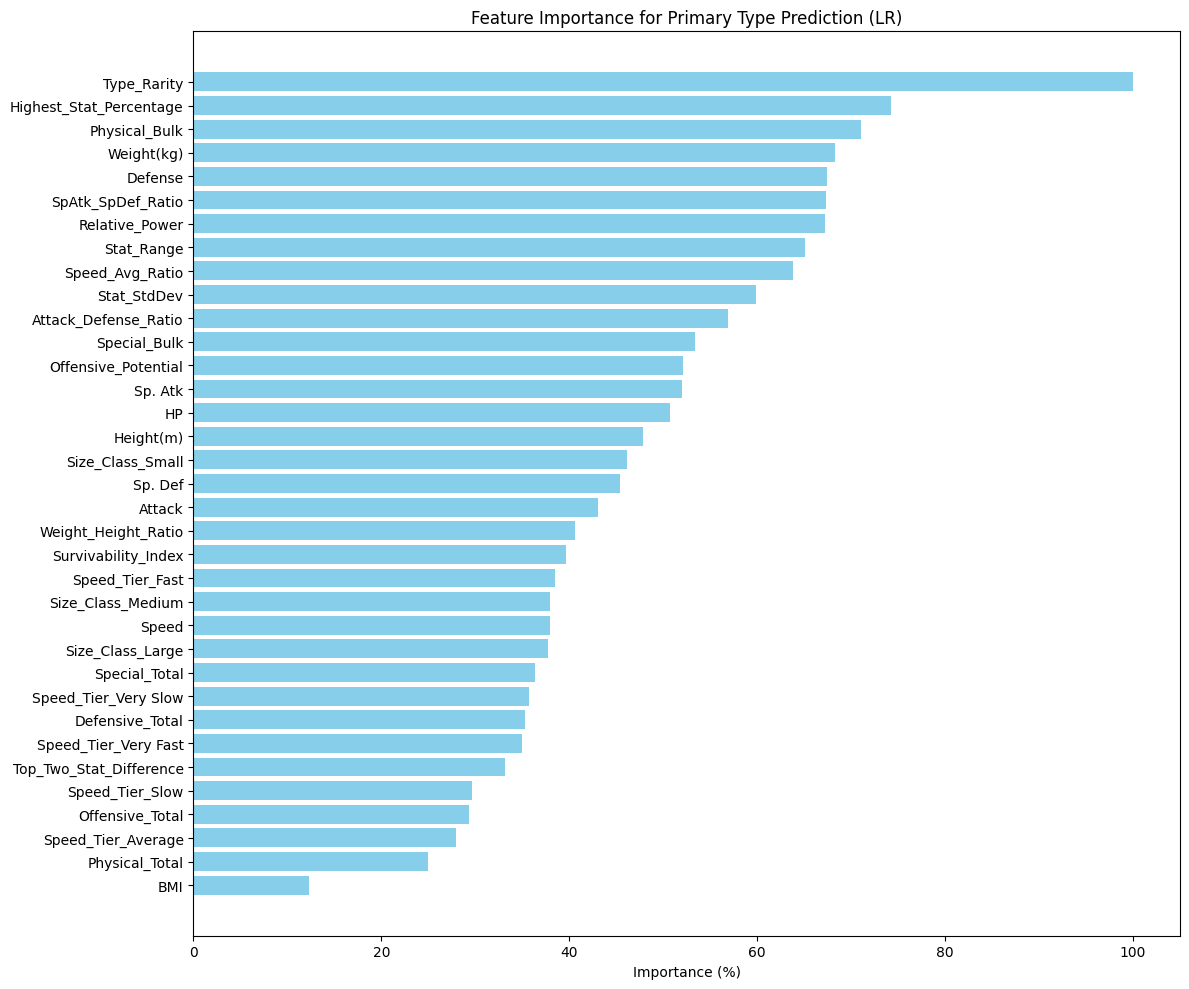

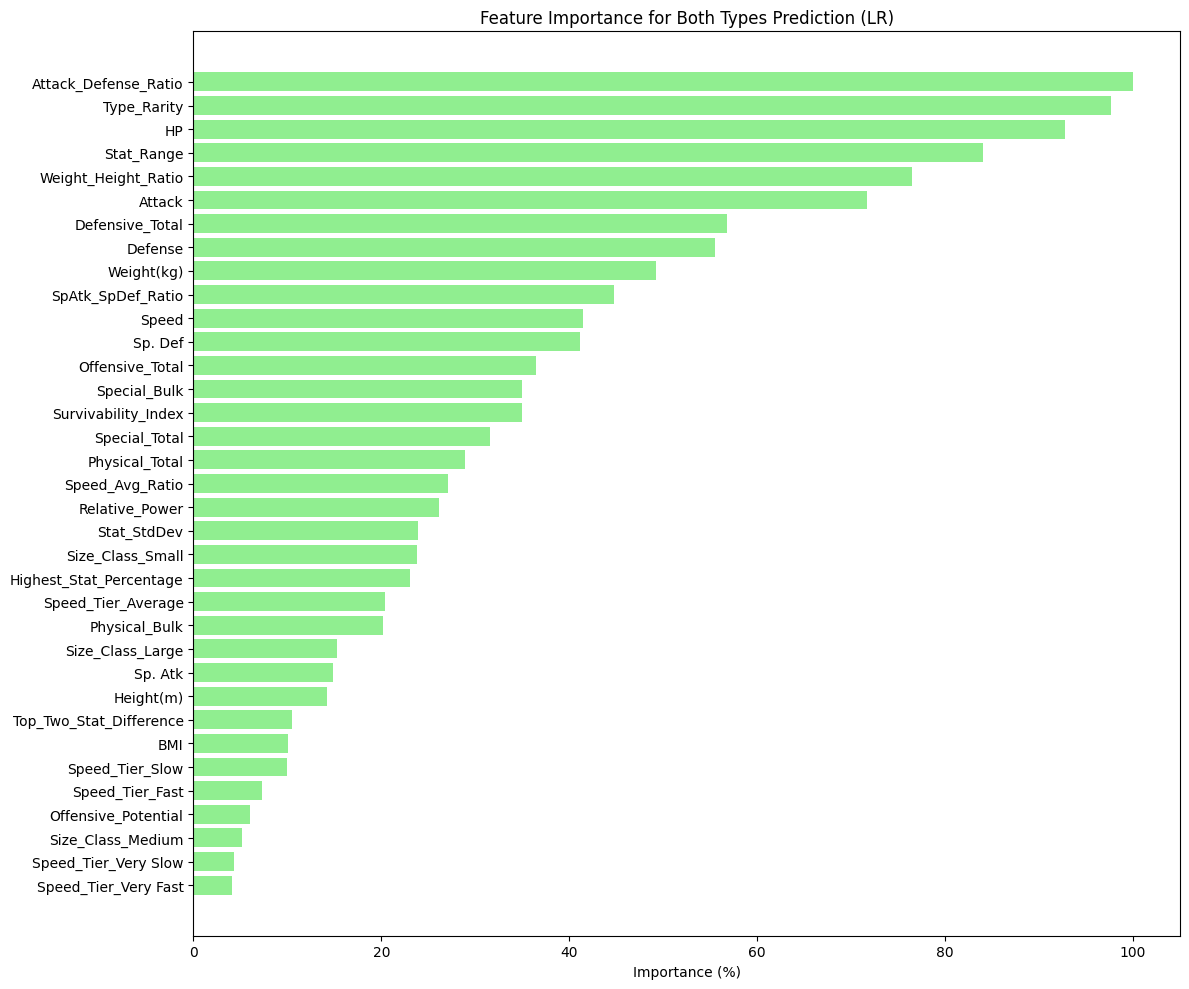

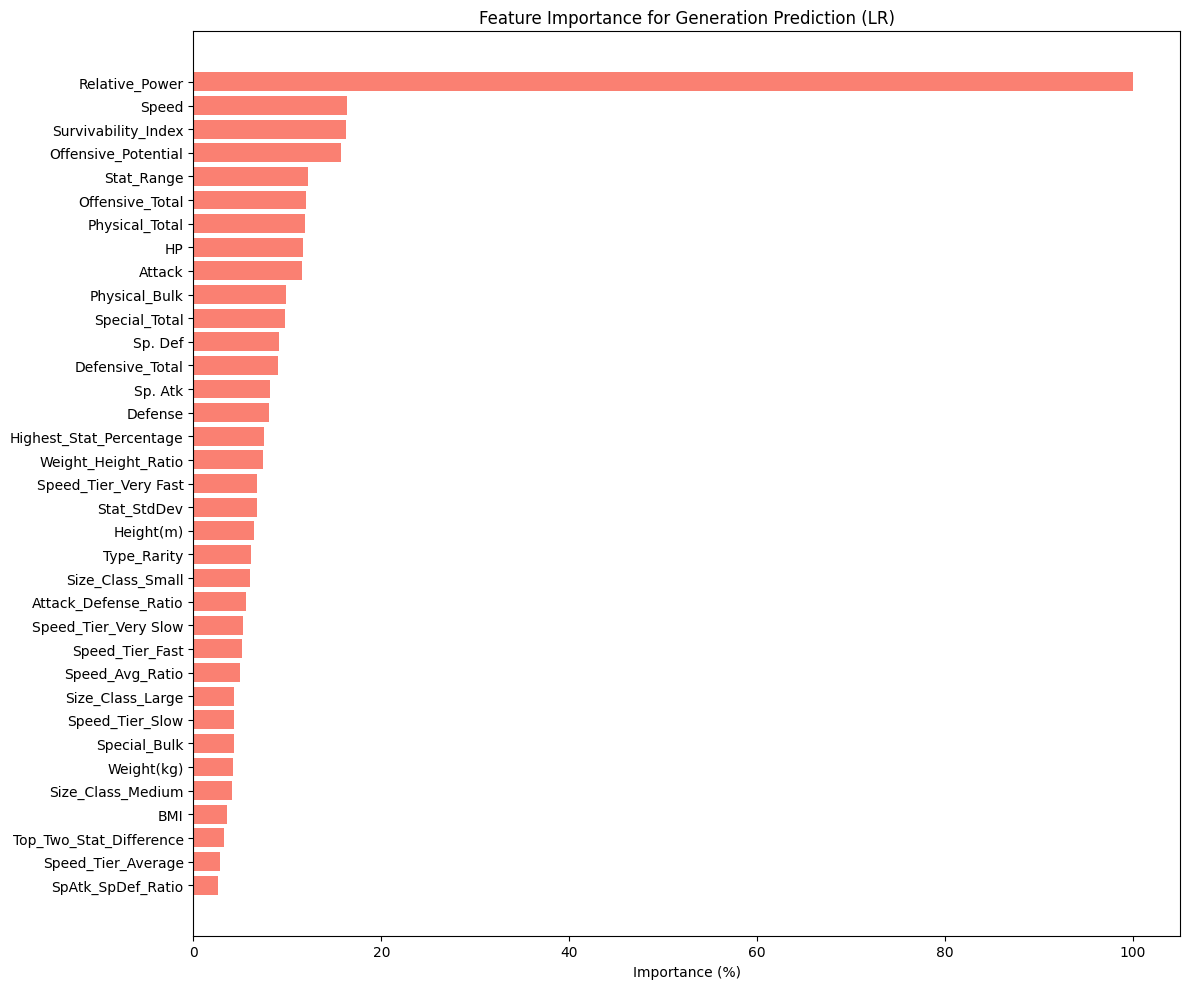

In [14]:
# Feature Importance for Engineered Features
import matplotlib.pyplot as plt
import numpy as np

# Combine all feature names
all_feature_names = all_features + list(X_train_cat.columns)

# Primary Type Feature Importance
primary_importance = np.abs(lr_primary.coef_).mean(axis=0)
primary_importance = 100.0 * (primary_importance / primary_importance.max())
sorted_primary_indices = np.argsort(primary_importance)[::-1]
sorted_primary_importance = primary_importance[sorted_primary_indices]
sorted_primary_features = [all_feature_names[i] for i in sorted_primary_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_primary_features, sorted_primary_importance, color='skyblue')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Primary Type Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Both Types Feature Importance
both_importance = np.abs(lr_both.estimators_[0].coef_).mean(axis=0)
both_importance = 100.0 * (both_importance / both_importance.max())
sorted_both_indices = np.argsort(both_importance)[::-1]
sorted_both_importance = both_importance[sorted_both_indices]
sorted_both_features = [all_feature_names[i] for i in sorted_both_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_both_features, sorted_both_importance, color='lightgreen')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Both Types Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Generation Feature Importance
gen_importance = np.abs(lr_generation.coef_).mean(axis=0)
gen_importance = 100.0 * (gen_importance / gen_importance.max())
sorted_gen_indices = np.argsort(gen_importance)[::-1]
sorted_gen_importance = gen_importance[sorted_gen_indices]
sorted_gen_features = [all_feature_names[i] for i in sorted_gen_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_gen_features, sorted_gen_importance, color='salmon')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Generation Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

## Image Features

In [ ]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('engineered_csv/train_image_features.csv')
test_df = pd.read_csv('engineered_csv/test_image_features.csv')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Prepare features and targets
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']

image_features = ['RGB_Mean', 'RGB_Std', 'RGB_Max', 'RGB_Min', 
                  'LBP_Mean', 'LBP_Std', 'LBP_Max', 'LBP_Min',
                  'CNN_Mean', 'CNN_Std', 'CNN_Max', 'CNN_Min']

all_features = original_features + image_features

X_train = train_df[all_features]
X_test = test_df[all_features]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Extract names separately
train_names = train_df['Name']
test_names = test_df['Name']

print("\nNumber of train samples:", len(train_names))
print("Number of test samples:", len(test_names))

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

print("\nUnique primary types in train:", y_train_primary.nunique())
print("Unique primary types in test:", y_test_primary.nunique())
print("Unique generations in train:", y_train_generation.nunique())
print("Unique generations in test:", y_test_generation.nunique())

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

print("\nSample of y_train_both:", y_train_both[:5])
print("Sample of y_test_both:", y_test_both[:5])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nX_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

print("\ny_train_both_bin shape:", y_train_both_bin.shape)
print("y_test_both_bin shape:", y_test_both_bin.shape)
print("Classes:", mlb.classes_)

print("\nSample of y_train_both_bin:", y_train_both_bin[:5])
print("Sample of y_test_both_bin:", y_test_both_bin[:5])

Train dataset shape: (820, 26)
Test dataset shape: (205, 26)
X_train shape: (820, 20)
X_test shape: (205, 20)

Number of train samples: 820
Number of test samples: 205

Unique primary types in train: 18
Unique primary types in test: 18
Unique generations in train: 9
Unique generations in test: 9

Sample of y_train_both: [['Dark', 'Psychic'], ['Psychic'], ['Psychic'], ['Normal', 'Flying'], ['Ghost']]
Sample of y_test_both: [['Dragon', 'Fighting'], ['Dark'], ['Normal', 'Psychic'], ['Grass'], ['Bug', 'Ground']]

X_train_scaled shape: (820, 20)
X_test_scaled shape: (205, 20)

y_train_both_bin shape: (820, 18)
y_test_both_bin shape: (205, 18)
Classes: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']

Sample of y_train_both_bin: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 

In [2]:
# Baseline without CV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score
import numpy as np

# Define evaluation metrics for both types
def precision_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    precisions = [np.sum(y_true[i, top_k_pred[i]]) / k for i in range(len(y_true))]
    return np.mean(precisions)

def recall_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    recalls = [np.sum(y_true[i, top_k_pred[i]]) / np.sum(y_true[i]) for i in range(len(y_true))]
    return np.mean(recalls)

# Primary Type
lr_primary = LogisticRegression(max_iter=1000)
lr_primary.fit(X_train_scaled, y_train_primary)
y_pred_primary = lr_primary.predict(X_test_scaled)
print("Logistic Regression - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types uses OneVsRestClassifier
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_both.fit(X_train_scaled, y_train_both_bin)

# Get probabilities for each class
y_pred_both_probas = lr_both.predict_proba(X_test_scaled)

# Initialize predictions array
y_pred_both = np.zeros_like(y_test_both_bin)

# Define a probability threshold
threshold = 0.5  # Adjust this threshold based on your needs

# Ensure at least one type is predicted for each Pokémon
for i in range(len(y_test_both_bin)):
    # Extract probabilities for each type for sample i
    probas = y_pred_both_probas[i]

    # Predict types with probabilities above the threshold
    above_threshold = probas >= threshold

    if not np.any(above_threshold):
        # If no type is above the threshold, predict the type with the highest probability
        max_index = probas.argmax()
        y_pred_both[i, max_index] = 1
    else:
        # Otherwise, predict all types above the threshold
        y_pred_both[i, above_threshold] = 1

print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")

# Calculate Precision@2 and Recall@2
precision_at_2 = precision_at_k(y_test_both_bin, y_pred_both_probas, k=2)
recall_at_2 = recall_at_k(y_test_both_bin, y_pred_both_probas, k=2)

print(f"Precision@2: {precision_at_2:.3f}")
print(f"Recall@2: {recall_at_2:.3f}")

# Generation
lr_generation = LogisticRegression(max_iter=1000)
lr_generation.fit(X_train_scaled, y_train_generation)
y_pred_generation = lr_generation.predict(X_test_scaled)
print("Logistic Regression - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Logistic Regression - Primary Type Accuracy: 0.2097560975609756
Logistic Regression - Both Types Hamming Loss: 0.10840108401084012
Exact Match Ratio: 0.112
Jaccard Similarity Score: 0.187
F1 Score: 0.213
Precision@2: 0.217
Recall@2: 0.320
Logistic Regression - Generation Accuracy: 0.32195121951219513


In [3]:
# Comprehensive Output of Model
import numpy as np
import pandas as pd

# Function to create DataFrame for misclassified and correctly classified cases
def create_classification_df(test_names, actual_labels, predicted_labels, label_type):
    misclassified_indices = np.where(actual_labels != predicted_labels)[0]
    correct_indices = np.where(actual_labels == predicted_labels)[0]

    # Misclassified DataFrame
    misclassified_df = pd.DataFrame({
        'Name': test_names.iloc[misclassified_indices],
        f'Actual {label_type}': actual_labels[misclassified_indices],
        f'Predicted {label_type}': predicted_labels[misclassified_indices]
    })

    # Correctly classified DataFrame
    correct_df = pd.DataFrame({
        'Name': test_names.iloc[correct_indices],
        f'Actual {label_type}': actual_labels[correct_indices],
        f'Predicted {label_type}': predicted_labels[correct_indices]
    })

    return misclassified_df, correct_df

# Primary Type Classification
misclassified_primary_df, correct_primary_df = create_classification_df(
    test_names,
    y_test_primary,
    y_pred_primary,
    "Primary"
)

# Both Types Classification
misclassified_both_indices = np.where(np.any(y_test_both_bin != y_pred_both, axis=1))[0]
correct_both_indices = np.where(np.all(y_test_both_bin == y_pred_both, axis=1))[0]

misclassified_both_df = pd.DataFrame({
    'Name': test_names.iloc[misclassified_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in misclassified_both_indices]
})

correct_both_df = pd.DataFrame({
    'Name': test_names.iloc[correct_both_indices],
    'Actual Types': [', '.join(mlb.inverse_transform(y_test_both_bin[idx].reshape(1, -1))[0]) for idx in correct_both_indices],
    'Predicted Types': [', '.join(mlb.inverse_transform(y_pred_both[idx].reshape(1, -1))[0]) for idx in correct_both_indices]
})

# Generation Classification
misclassified_generation_df, correct_generation_df = create_classification_df(
    test_names,
    y_test_generation,
    y_pred_generation,
    "Generation"
)

# Print results
print("Misclassified Primary Types:")
print(misclassified_primary_df.head())
print(f"Total misclassifications: {len(misclassified_primary_df)}")
print(f"Misclassification rate: {len(misclassified_primary_df) / len(y_test_primary):.2%}\n")

print("Correctly Classified Primary Types:")
print(correct_primary_df.head())
print(f"Total correct classifications: {len(correct_primary_df)}")
print(f"Correct classification rate: {len(correct_primary_df) / len(y_test_primary):.2%}\n")

print("Misclassified Both Types:")
print(misclassified_both_df.head())
print(f"Total misclassifications: {len(misclassified_both_df)}")
print(f"Misclassification rate: {len(misclassified_both_df) / len(y_test_both_bin):.2%}\n")

print("Correctly Classified Both Types:")
print(correct_both_df.head())
print(f"Total correct classifications: {len(correct_both_df)}")
print(f"Correct classification rate: {len(correct_both_df) / len(y_test_both_bin):.2%}\n")

print("Misclassified Generations:")
print(misclassified_generation_df.head())
print(f"Total misclassifications: {len(misclassified_generation_df)}")
print(f"Misclassification rate: {len(misclassified_generation_df) / len(y_test_generation):.2%}\n")

print("Correctly Classified Generations:")
print(correct_generation_df.head())
print(f"Total correct classifications: {len(correct_generation_df)}")
print(f"Correct classification rate: {len(correct_generation_df) / len(y_test_generation):.2%}\n")

Misclassified Primary Types:
         Name Actual Primary Predicted Primary
0    Hakamo-o         Dragon               Bug
2    Meloetta         Normal           Psychic
3    Meganium          Grass             Water
4     Nincada            Bug             Steel
5  Conkeldurr       Fighting            Normal
Total misclassifications: 162
Misclassification rate: 79.02%

Correctly Classified Primary Types:
          Name Actual Primary Predicted Primary
1        Absol           Dark              Dark
9    Poliwrath          Water             Water
18  Bouffalant         Normal            Normal
19      Bidoof         Normal            Normal
20        Sawk       Fighting          Fighting
Total correct classifications: 43
Correct classification rate: 20.98%

Misclassified Both Types:
       Name      Actual Types Predicted Types
0  Hakamo-o  Dragon, Fighting           Water
1     Absol              Dark        Fighting
2  Meloetta   Normal, Psychic         Psychic
3  Meganium           

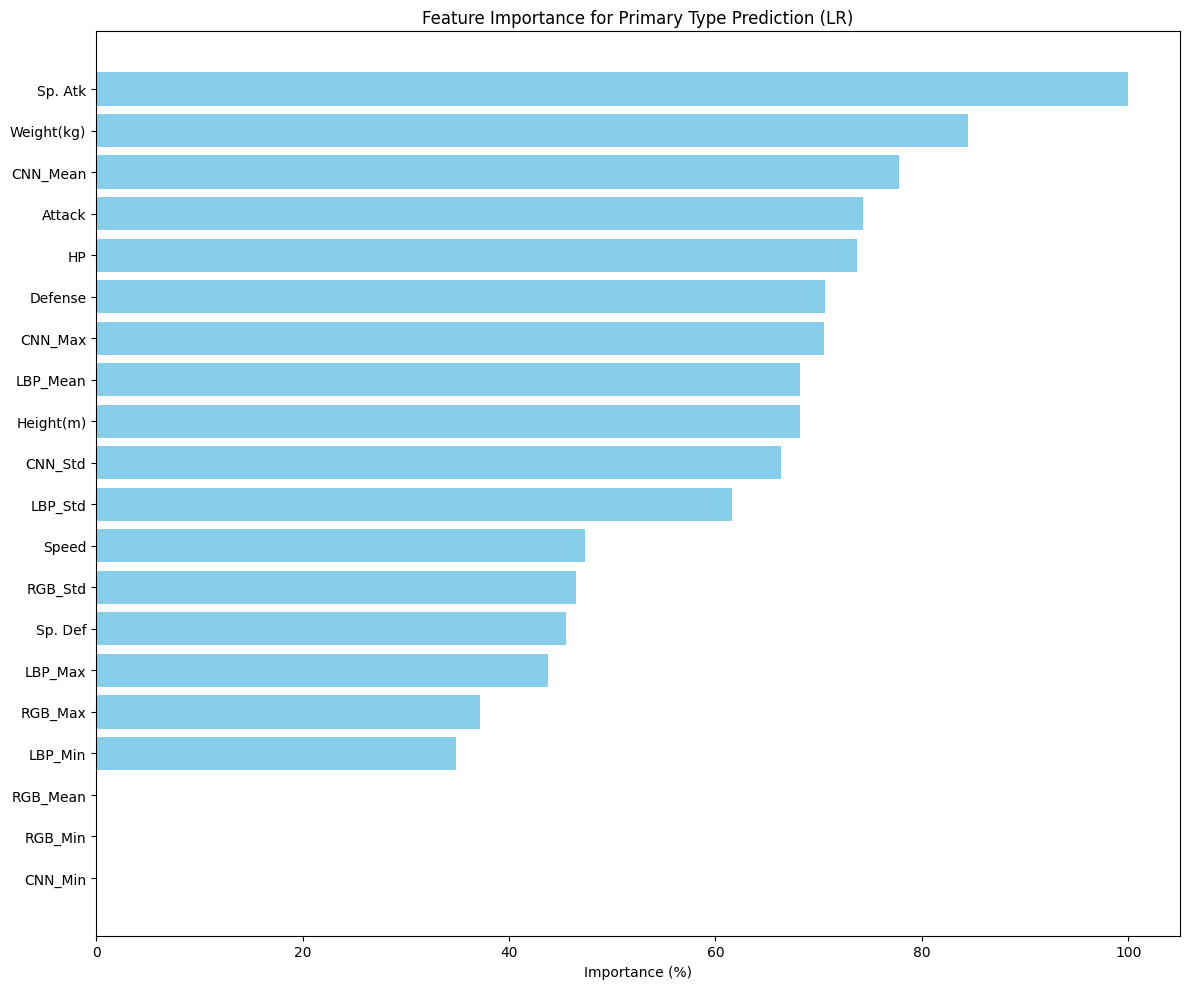

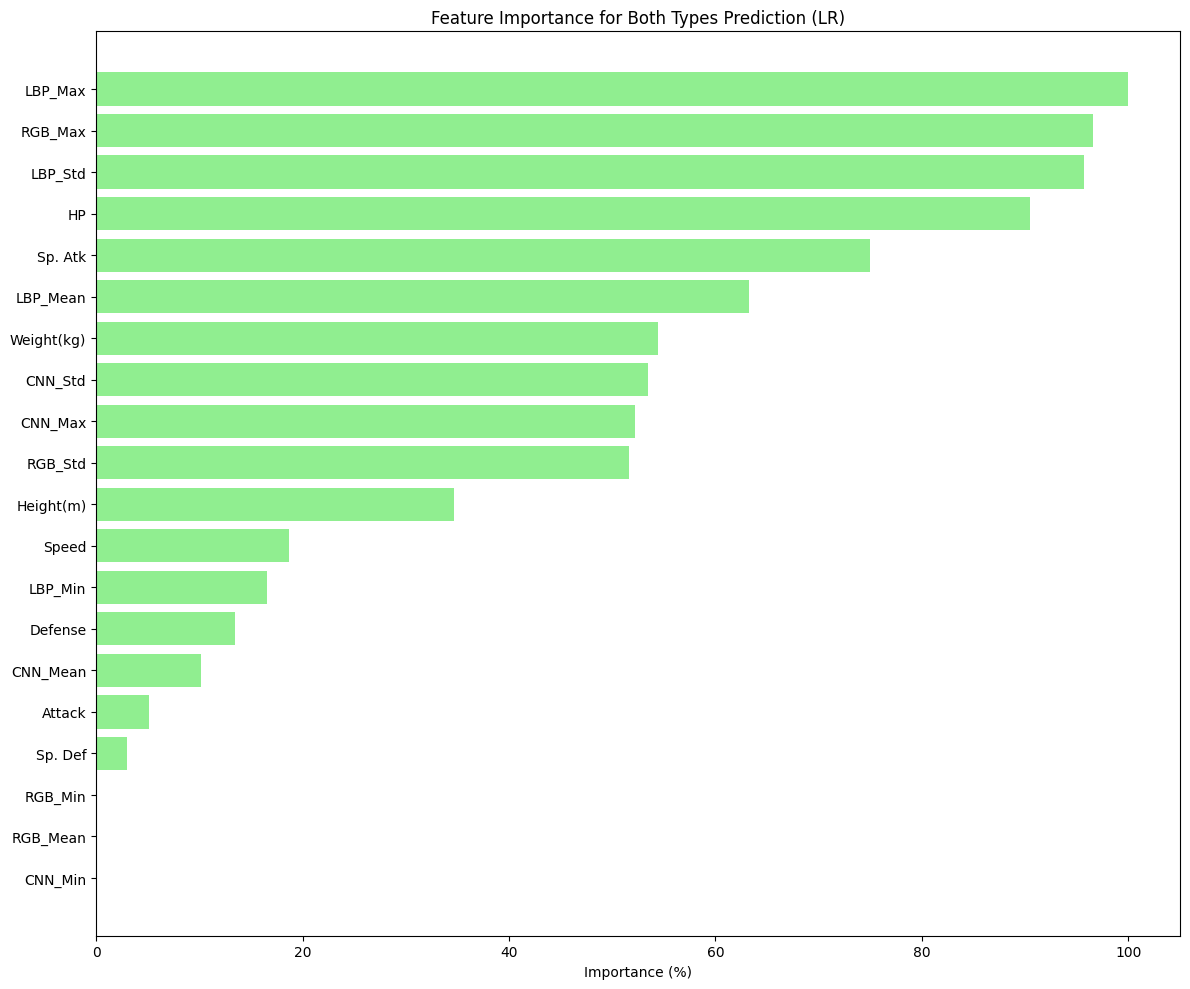

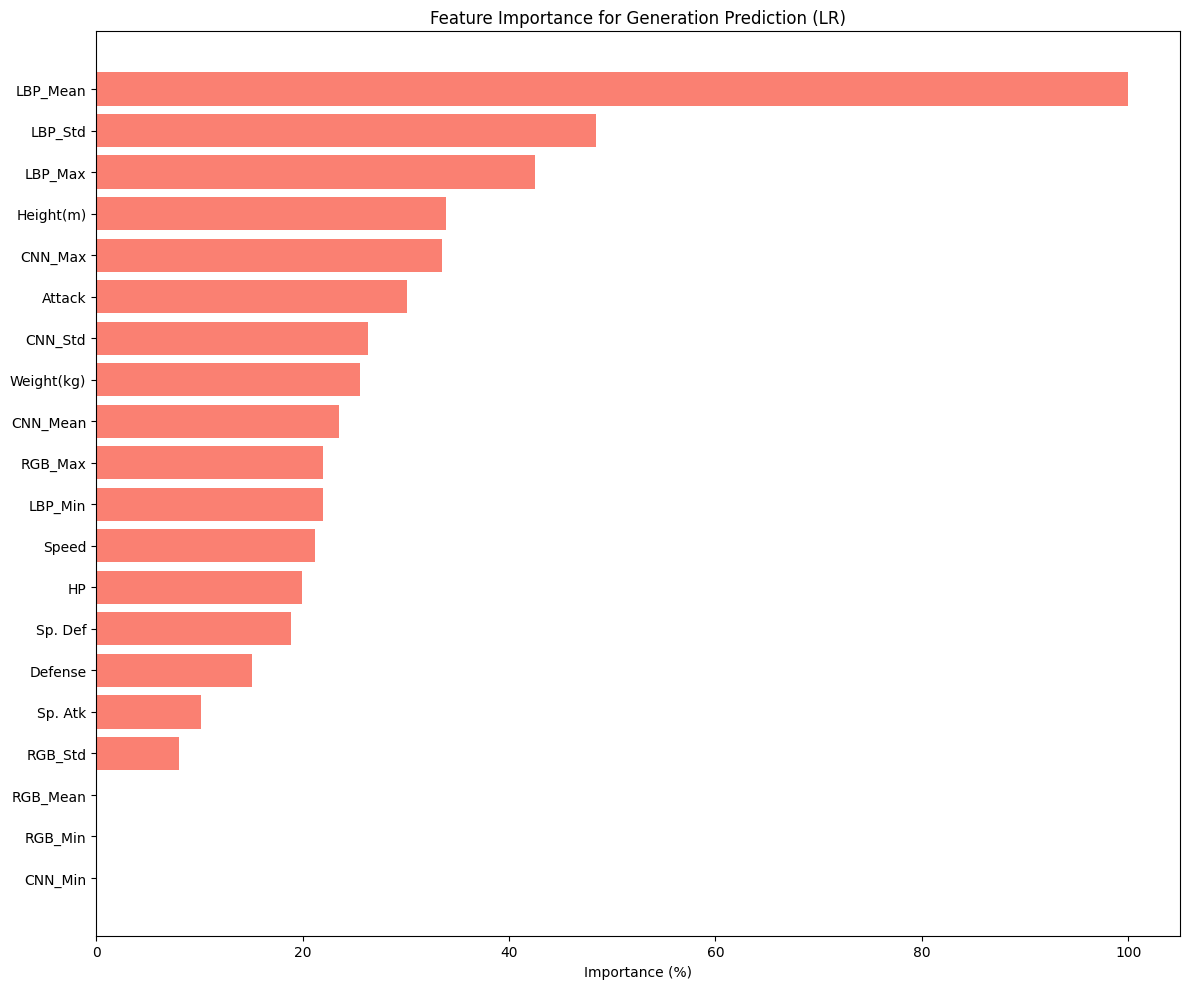

In [4]:
# Feature Importance for Engineered Features
import matplotlib.pyplot as plt
import numpy as np

# Combine all feature names
all_feature_names = all_features 

# Primary Type Feature Importance
primary_importance = np.abs(lr_primary.coef_).mean(axis=0)
primary_importance = 100.0 * (primary_importance / primary_importance.max())
sorted_primary_indices = np.argsort(primary_importance)[::-1]
sorted_primary_importance = primary_importance[sorted_primary_indices]
sorted_primary_features = [all_feature_names[i] for i in sorted_primary_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_primary_features, sorted_primary_importance, color='skyblue')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Primary Type Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Both Types Feature Importance
both_importance = np.abs(lr_both.estimators_[0].coef_).mean(axis=0)
both_importance = 100.0 * (both_importance / both_importance.max())
sorted_both_indices = np.argsort(both_importance)[::-1]
sorted_both_importance = both_importance[sorted_both_indices]
sorted_both_features = [all_feature_names[i] for i in sorted_both_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_both_features, sorted_both_importance, color='lightgreen')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Both Types Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Generation Feature Importance
gen_importance = np.abs(lr_generation.coef_).mean(axis=0)
gen_importance = 100.0 * (gen_importance / gen_importance.max())
sorted_gen_indices = np.argsort(gen_importance)[::-1]
sorted_gen_importance = gen_importance[sorted_gen_indices]
sorted_gen_features = [all_feature_names[i] for i in sorted_gen_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_gen_features, sorted_gen_importance, color='salmon')
plt.xlabel('Importance (%)')
plt.title('Feature Importance for Generation Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

## Feature Selection

### We combine all features to see what the most important ones are.

In [2]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('engineered_csv/train_combined_features.csv')
test_df = pd.read_csv('engineered_csv/test_combined_features.csv')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Prepare features and targets
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
image_features = ['RGB_Mean', 'RGB_Std', 'RGB_Max', 'RGB_Min', 
                  'LBP_Mean', 'LBP_Std', 'LBP_Max', 'LBP_Min',
                  'CNN_Mean', 'CNN_Std', 'CNN_Max', 'CNN_Min']
engineered_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

all_features = original_features + engineered_features + image_features

# Check if all features are present in the dataframes
missing_features = [f for f in all_features if f not in train_df.columns or f not in test_df.columns]
if missing_features:
    print("Warning: The following features are missing:", missing_features)
    all_features = [f for f in all_features if f not in missing_features]

X_train = train_df[all_features]
X_test = test_df[all_features]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Extract names separately
train_names = train_df['Name']
test_names = test_df['Name']

print("\nNumber of train samples:", len(train_names))
print("Number of test samples:", len(test_names))

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

print("\nUnique primary types in train:", y_train_primary.nunique())
print("Unique primary types in test:", y_test_primary.nunique())
print("Unique generations in train:", y_train_generation.nunique())
print("Unique generations in test:", y_test_generation.nunique())

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

print("\nSample of y_train_both:", y_train_both[:5])
print("Sample of y_test_both:", y_test_both[:5])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nX_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

print("\ny_train_both_bin shape:", y_train_both_bin.shape)
print("y_test_both_bin shape:", y_test_both_bin.shape)
print("Classes:", mlb.classes_)

print("\nSample of y_train_both_bin:", y_train_both_bin[:5])
print("Sample of y_test_both_bin:", y_test_both_bin[:5])

# Handle categorical features
categorical_features = ['Size_Class', 'Speed_Tier']
X_train_cat = pd.get_dummies(train_df[categorical_features], prefix=categorical_features)
X_test_cat = pd.get_dummies(test_df[categorical_features], prefix=categorical_features)

# Ensure test set has all columns present in train set
for col in X_train_cat.columns:
    if col not in X_test_cat.columns:
        X_test_cat[col] = 0

# Align columns of test set with train set
X_test_cat = X_test_cat[X_train_cat.columns]

# Combine scaled numerical features with categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

print("\nX_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

Train dataset shape: (820, 47)
Test dataset shape: (205, 47)
X_train shape: (820, 39)
X_test shape: (205, 39)

Number of train samples: 820
Number of test samples: 205

Unique primary types in train: 18
Unique primary types in test: 18
Unique generations in train: 9
Unique generations in test: 9

Sample of y_train_both: [['Dark', 'Psychic'], ['Psychic'], ['Psychic'], ['Normal', 'Flying'], ['Ghost']]
Sample of y_test_both: [['Dragon', 'Fighting'], ['Dark'], ['Normal', 'Psychic'], ['Grass'], ['Bug', 'Ground']]

X_train_scaled shape: (820, 39)
X_test_scaled shape: (205, 39)

y_train_both_bin shape: (820, 18)
y_test_both_bin shape: (205, 18)
Classes: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']

Sample of y_train_both_bin: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 

In [3]:
# Baseline without CV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, f1_score
import numpy as np

# Define evaluation metrics for both types
def precision_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    precisions = [np.sum(y_true[i, top_k_pred[i]]) / k for i in range(len(y_true))]
    return np.mean(precisions)

def recall_at_k(y_true, y_pred_proba, k=2):
    top_k_pred = np.argsort(y_pred_proba, axis=1)[:, -k:]
    recalls = [np.sum(y_true[i, top_k_pred[i]]) / np.sum(y_true[i]) for i in range(len(y_true))]
    return np.mean(recalls)

# Primary Type
lr_primary = LogisticRegression(max_iter=1000)
lr_primary.fit(X_train_final, y_train_primary)
y_pred_primary = lr_primary.predict(X_test_final)
print("Logistic Regression - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types uses OneVsRestClassifier
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_both.fit(X_train_final, y_train_both_bin)

# Get probabilities for each class
y_pred_both_probas = lr_both.predict_proba(X_test_final)

# Initialize predictions array
y_pred_both = np.zeros_like(y_test_both_bin)

# Define a probability threshold
threshold = 0.5  # Adjust this threshold based on your needs

# Ensure at least one type is predicted for each Pokémon
for i in range(len(y_test_both_bin)):
    probas = y_pred_both_probas[i]
    above_threshold = probas >= threshold
    if not np.any(above_threshold):
        max_index = probas.argmax()
        y_pred_both[i, max_index] = 1
    else:
        y_pred_both[i, above_threshold] = 1

print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Calculate additional metrics
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')

print(f"Exact Match Ratio: {exact_match_ratio:.3f}")
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")
print(f"F1 Score: {f1_score_value:.3f}")

# Calculate Precision@2 and Recall@2
precision_at_2 = precision_at_k(y_test_both_bin, y_pred_both_probas, k=2)
recall_at_2 = recall_at_k(y_test_both_bin, y_pred_both_probas, k=2)

print(f"Precision@2: {precision_at_2:.3f}")
print(f"Recall@2: {recall_at_2:.3f}")

# Generation
lr_generation = LogisticRegression(max_iter=1000)
lr_generation.fit(X_train_final, y_train_generation)
y_pred_generation = lr_generation.predict(X_test_final)
print("Logistic Regression - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Logistic Regression - Primary Type Accuracy: 0.22926829268292684
Logistic Regression - Both Types Hamming Loss: 0.11517615176151762
Exact Match Ratio: 0.107
Jaccard Similarity Score: 0.166
F1 Score: 0.186
Precision@2: 0.212
Recall@2: 0.315
Logistic Regression - Generation Accuracy: 0.43902439024390244


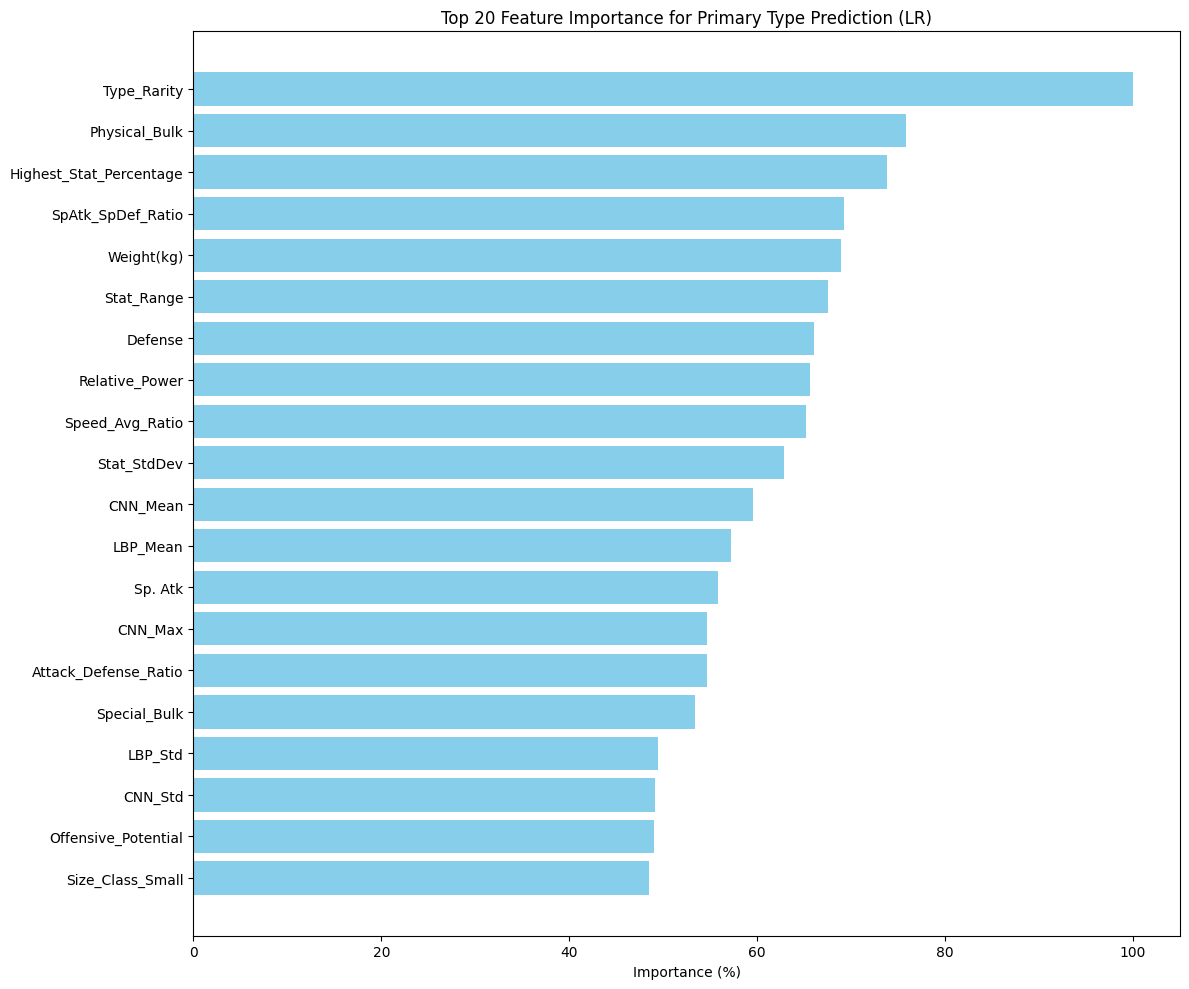

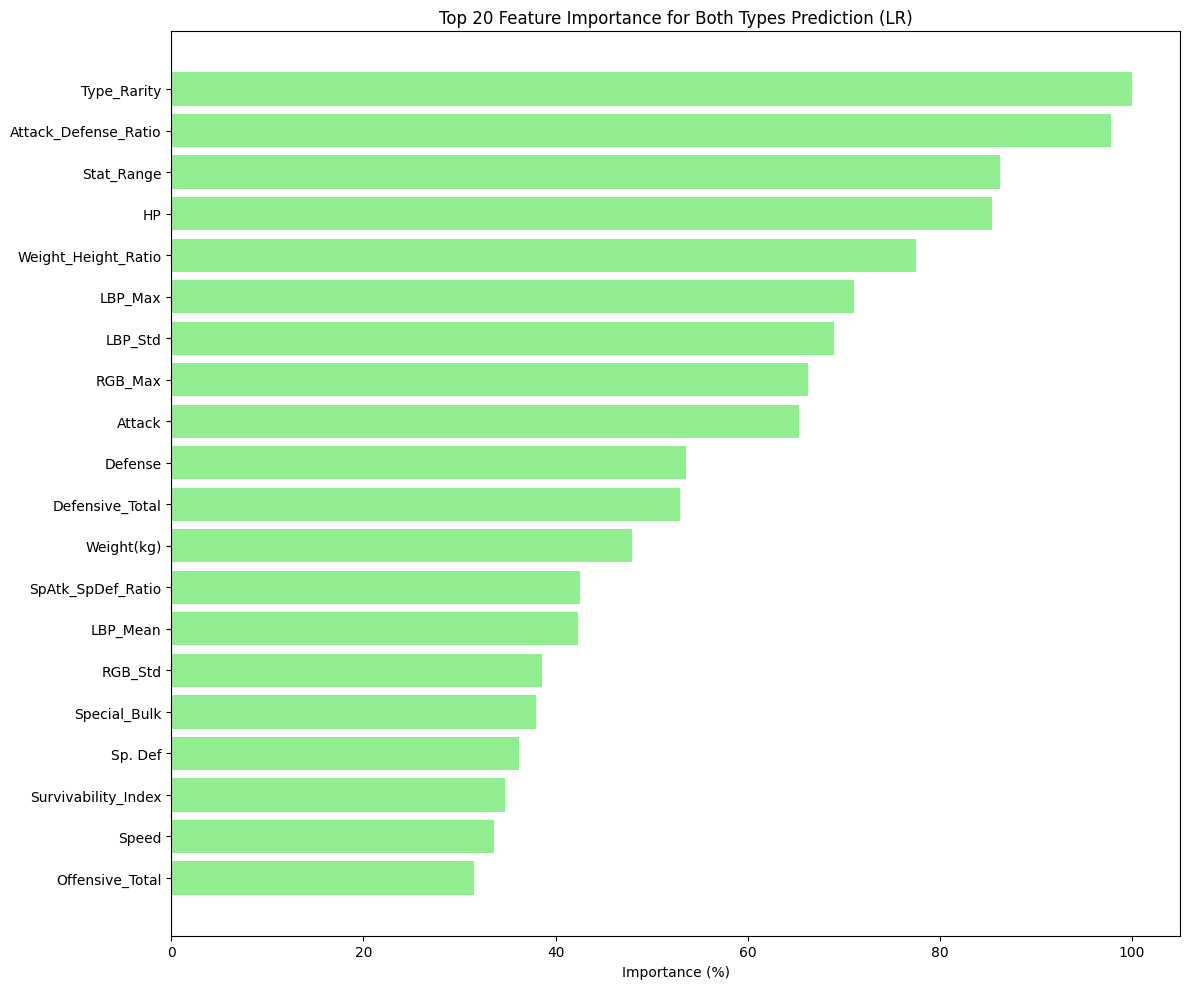

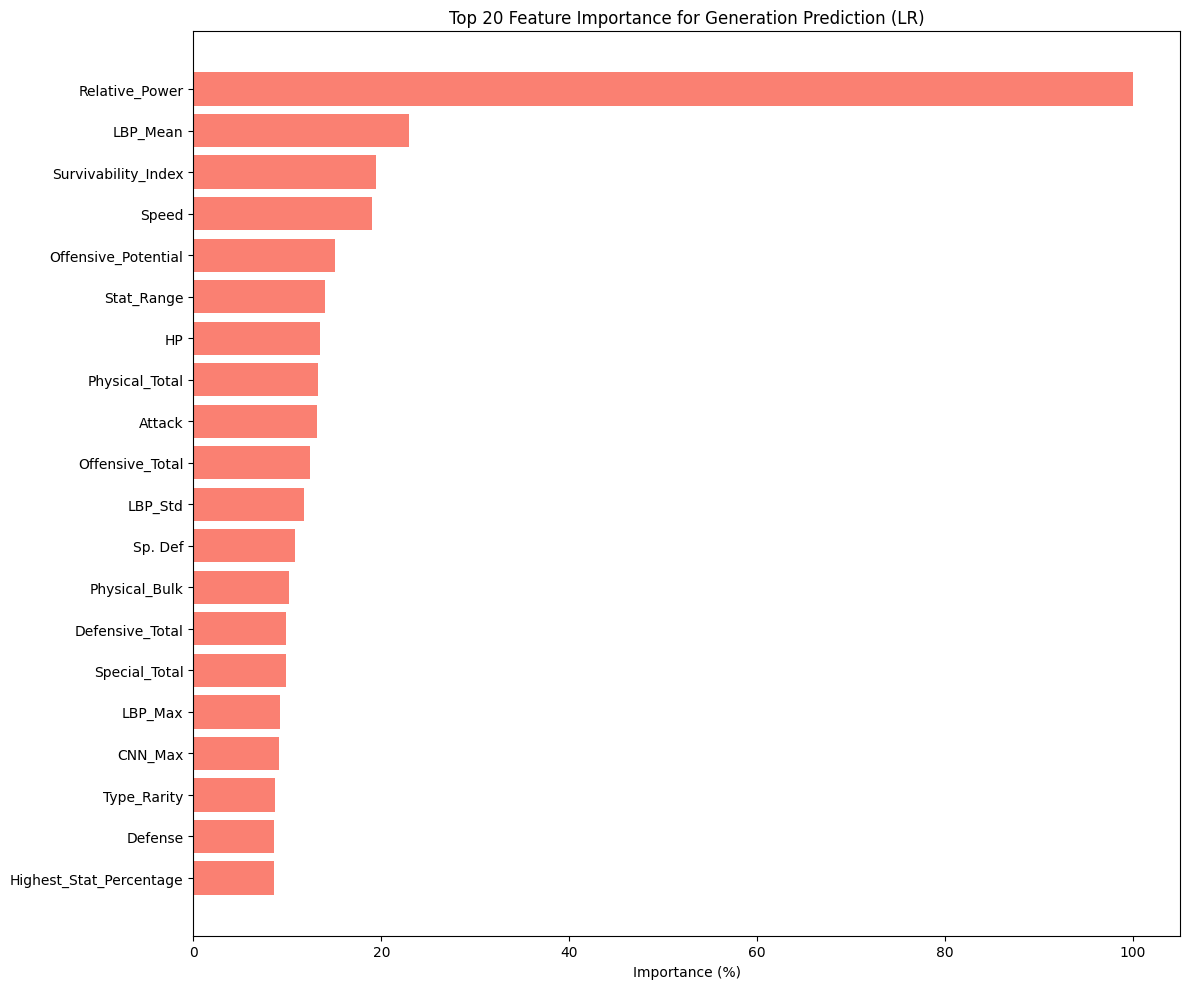

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get all feature names, including one-hot encoded categorical features
all_feature_names = all_features + list(X_train_cat.columns)

# Primary Type Feature Importance
primary_importance = np.abs(lr_primary.coef_).mean(axis=0)
primary_importance = 100.0 * (primary_importance / primary_importance.max())
sorted_primary_indices = np.argsort(primary_importance)[::-1]
sorted_primary_importance = primary_importance[sorted_primary_indices]
sorted_primary_features = [all_feature_names[i] for i in sorted_primary_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_primary_features[:20], sorted_primary_importance[:20], color='skyblue')
plt.xlabel('Importance (%)')
plt.title('Top 20 Feature Importance for Primary Type Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Both Types Feature Importance
both_importance = np.abs(lr_both.estimators_[0].coef_).mean(axis=0)
both_importance = 100.0 * (both_importance / both_importance.max())
sorted_both_indices = np.argsort(both_importance)[::-1]
sorted_both_importance = both_importance[sorted_both_indices]
sorted_both_features = [all_feature_names[i] for i in sorted_both_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_both_features[:20], sorted_both_importance[:20], color='lightgreen')
plt.xlabel('Importance (%)')
plt.title('Top 20 Feature Importance for Both Types Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Generation Feature Importance
gen_importance = np.abs(lr_generation.coef_).mean(axis=0)
gen_importance = 100.0 * (gen_importance / gen_importance.max())
sorted_gen_indices = np.argsort(gen_importance)[::-1]
sorted_gen_importance = gen_importance[sorted_gen_indices]
sorted_gen_features = [all_feature_names[i] for i in sorted_gen_indices]

plt.figure(figsize=(12, 10))
plt.barh(sorted_gen_features[:20], sorted_gen_importance[:20], color='salmon')
plt.xlabel('Importance (%)')
plt.title('Top 20 Feature Importance for Generation Prediction (LR)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

## Visualizations